In [3]:
%pylab inline
from astropy.io import fits
import astropy.units as u
import pickle as pickle
import os as os
import pandas as pd

from spectools_ir.utils import extract_hitran_data, spec_convol, make_rotation_diagram, get_molmass
from spectools_ir.utils import compute_thermal_velocity, sigma_to_fwhm, fwhm_to_sigma, wn_to_k, spec_convol_R
from spectools_ir.utils import get_miri_mrs_resolution, get_miri_mrs_wavelengths, make_miri_mrs_figure

from spectools_ir.flux_calculator import calc_fluxes, make_lineshape

from spectools_ir.slabspec import make_spec

from spectools_ir.slab_fitter import Config, LineData,Retrieval
from spectools_ir.slab_fitter import corner_plot, trace_plot, find_best_fit, compute_model_fluxes
from spectools_ir.slab_fitter import calc_solid_angle, calc_radius
from spectools_ir.slab_fitter import read_data_from_file, get_samples

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
import spectools_ir
print(spectools_ir.__file__)

/Users/belaarwen/opt/anaconda3/lib/python3.9/site-packages/spectools_ir/__init__.py


In [9]:
hitran_data_CO  = extract_hitran_data('CO',4.6,5.42,vup=1)                     #calling for CO lines
hitran_data_H2O = extract_hitran_data('H2O',4.6,5.42,eupmax=5000,aupmin=0)    #calling for H2O lines 
                                                                            #eupmax gives a maximum to the energy transition in ___?
                                                                            #aupmin gives einstein "a" coeifficient

#This line calls to the hitran dataset and labels an astropy table as "hitran_data". 
#We are calling for CO and H2O from the 5.3 to the 5.42 micron regime 

In [10]:
extract_hitran_data

<function spectools_ir.utils.utils.extract_hitran_data(molecule_name, wavemin, wavemax, isotopologue_number=1, eupmax=None, aupmin=None, swmin=None, vup=None)>

In [11]:
sources_list = ['CITau','FZTau','IQTau']    #3 sources with the new regime
#sources_list = ['AS205','CITau','DoAr25','DoAr33','FZTau','GKTau','HD143006','HPTau','IQTau','IRAS04385','WSB52'] #all 11 sources, some without the new regime

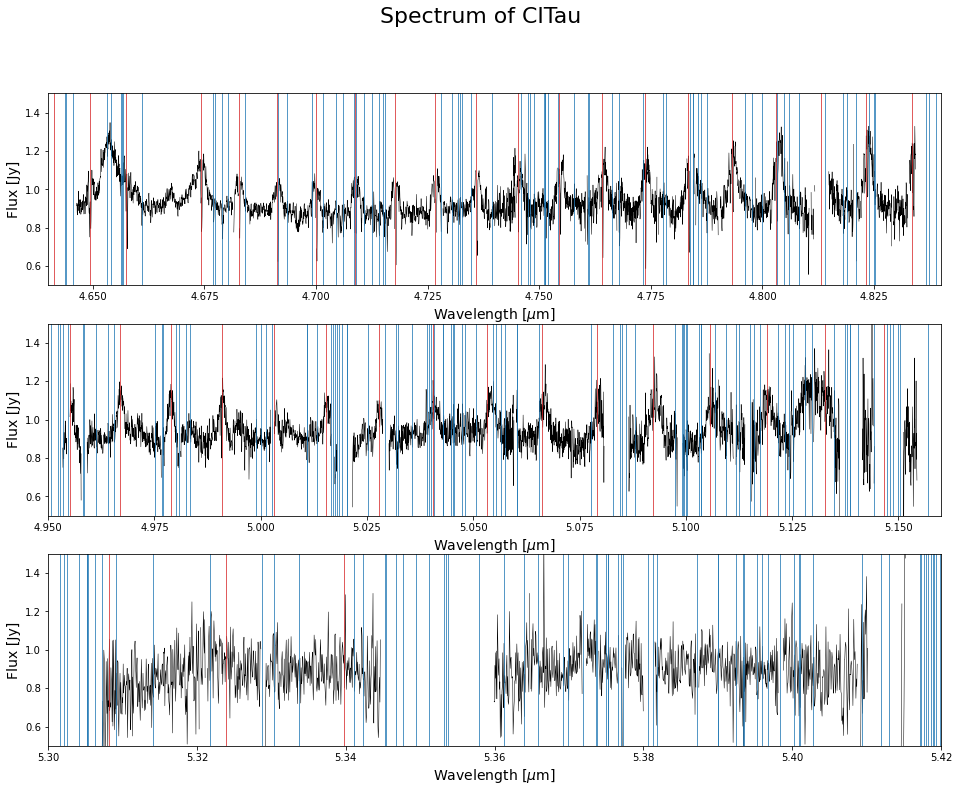

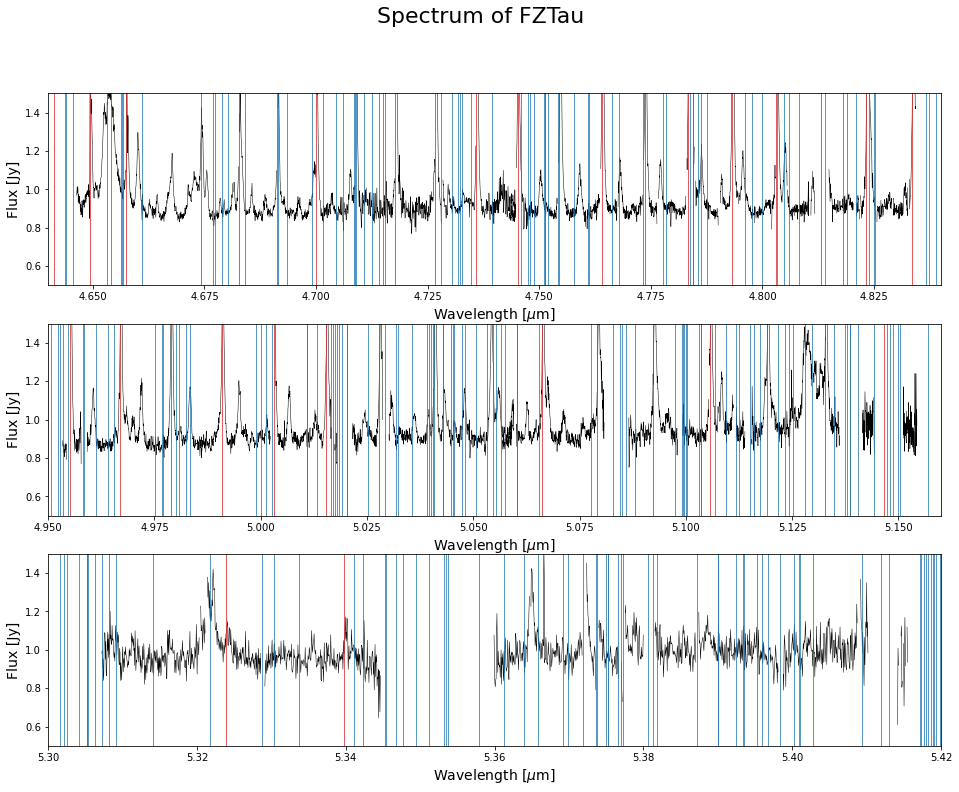

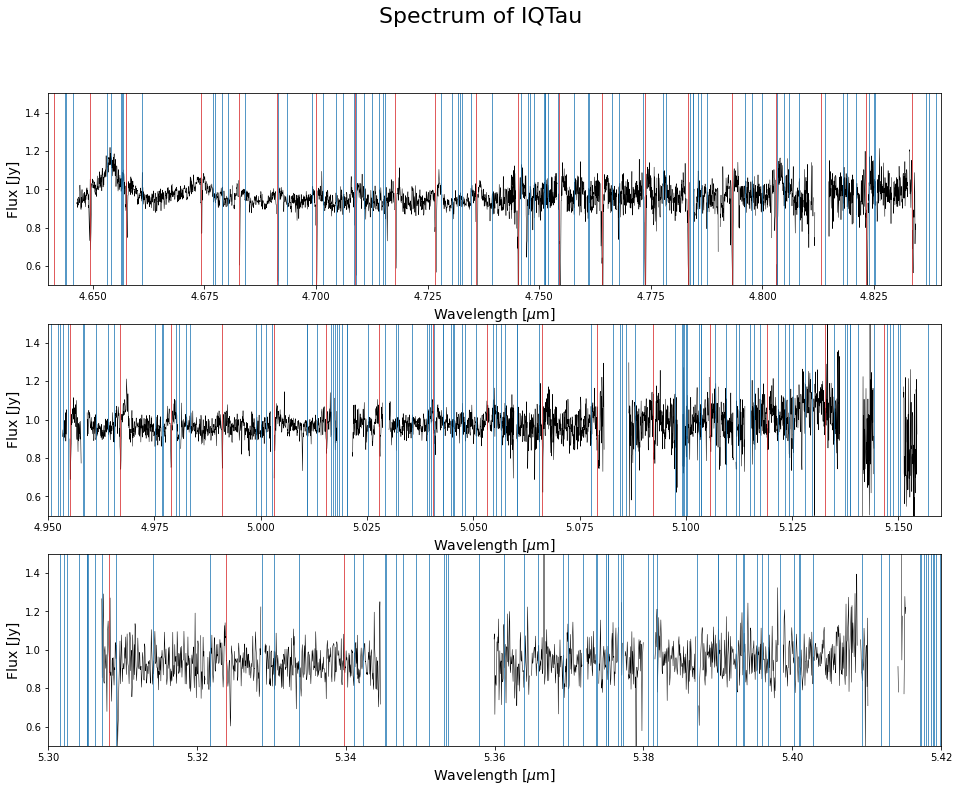

In [12]:
for i in sources_list:
    infile  = '/Users/belaarwen/Desktop/Vassar/Astronomy/Thesis/reducs22/'+i+'_orders.fits'
    hdulist = fits.open(infile)      #hdu means header data unit so we are creating a list of header data units to use in further files
    data    = hdulist[1].data
    wave    = data['wave']
    flux    = data['flux']
    
#creating
    fig = plt.figure(figsize = (16,12))
    fig.suptitle('Spectrum of ' +i, fontsize = 22)
#
    ax1 = fig.add_subplot(311)
    ax1.plot(wave,flux, linewidth=0.5, color='k')
    ax1.set_xlim(4.64, 4.84)
    for i,lam in enumerate(hitran_data_CO['wave']):
        if((lam>4.64) & (lam<4.84)):
            ax1.axvline(lam, linewidth=0.75, color='tab:red') 
    for i,lam in enumerate(hitran_data_H2O['wave']):
        if((lam>4.64) & (lam<4.84)):
            ax1.axvline(lam, linewidth=0.75, color='tab:blue') 
    ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
    ax1.set_ylabel('Flux [Jy]', fontsize=14)
    ax1.set_ylim(0.5,1.5)
    
    ax2 = fig.add_subplot(312)
    ax2.plot(wave,flux, linewidth=0.5, color='k')
    ax2.set_xlim(4.95, 5.16)
    for i,lam in enumerate(hitran_data_CO['wave']):
        if((lam>4.95) & (lam<5.16)):
            ax2.axvline(lam, linewidth=0.75, color='tab:red')
    for i,lam in enumerate(hitran_data_H2O['wave']):
        if((lam>4.95) & (lam<5.16)):
            ax2.axvline(lam, linewidth=0.75, color='tab:blue')         
    ax2.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
    ax2.set_ylabel('Flux [Jy]', fontsize=14)
    ax2.set_ylim(0.5,1.5)

#creating a third subplot for the new reegime 

    ax3 = fig.add_subplot(313)
    ax3.plot(wave,flux, linewidth=0.5, color='k')
    ax3.set_xlim(5.3, 5.42)
    for i,lam in enumerate(hitran_data_CO['wave']):
        if((lam>5.3) & (lam<5.42)):
            ax3.axvline(lam, linewidth=0.75, color='tab:red')
    for i,lam in enumerate(hitran_data_H2O['wave']):
        if((lam>5.3) & (lam<5.42)):
            ax3.axvline(lam, linewidth=0.75, color='tab:blue')         
    ax3.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
    ax3.set_ylabel('Flux [Jy]', fontsize=14)
    ax3.set_ylim(0.5,1.5)
    

wider CO lines should indicate wider lines for all molecules. We should not expect the H2O features to be sharp if the CO lines are wide

Notice the seemingly water line in IQ Tau @ 4.745

In [13]:
data

FITS_rec([(5.30450156, nan, nan, nan, 1.25890824e+04),
          (5.30455452, nan, nan, nan, 9.03112688e+03),
          (5.30460748, nan, nan, nan, 9.03112818e+03), ...,
          (4.834921  , nan, nan, nan, 8.33967142e+01),
          (4.83496736, nan, nan, nan, 2.11164890e+00),
          (4.83501372, nan, nan, nan, 1.09683605e+00)],
         dtype=(numpy.record, [('wave', '>f8'), ('flux', '>f8'), ('uflux', '>f8'), ('sa', '>f8'), ('usa', '>f8')]))